# K562 CRE meta analysis

## Make new directories

In [4]:
%%bash
mkdir -p k562meta/elementReference/hg38
mkdir -p k562meta/elementQuant/hg38
mkdir -p k562meta/elementReference/hg19
mkdir -p k562meta/elementQuant/hg19
mkdir -p k562meta/elementReference/hg19_to_hg38
mkdir -p k562meta/elementQuant/hg19_to_hg38
mkdir -p k562meta/combined
mkdir -p k562meta/outs

## Switch to `R` kernel

In [1]:
suppressPackageStartupMessages(library(tidyverse))

## Generate master hg19 elementReference file

### Load both elementReference files

In [2]:
temp1 <- read_tsv("k562meta/elementReference/hg19/ENCFF287WXB.tsv",
                  col_names = TRUE, show_col_types = FALSE)
head(temp1,n=1)

chr,start,end,GuideSequence,OligoID
<chr>,<dbl>,<dbl>,<chr>,<chr>
chrX,48645094,48645113,GGGTAGGGGCAGCAGGCCCA,171010FF_12166


In [3]:
temp2 <- read_tsv("k562meta/elementReference/hg19/ENCFF647EBF.tsv",
                  col_names = TRUE, show_col_types = FALSE)
head(temp2,n=1)

OligoID,target
<chr>,<chr>
171010FF_12166,chrX:48644125-48645245


### Now, combine all targeting sgRNAs into one dataframe and clean

Goal here is to get the sgRNA coordinates and attach a unique label for the sgRNA, then remove duplicates.

In [4]:
df1 <- 
rbind(
    temp1 %>%
        filter(grepl("chr",chr)) %>%
        mutate(label = paste0(OligoID,"_",chr,"_",start,"_",end)) %>%
        select(chr, start, end, label, OligoID) %>%
        distinct(),
    
    temp2 %>%
        filter(grepl("chr",target)) %>%
        separate(target, into = c("chr","coords"), remove = FALSE, sep = ":") %>%
        separate(coords, into = c("start","end"), remove = FALSE, sep = "-") %>%
        mutate(label = paste0(OligoID,"_",chr,"_",coords)) %>%
        select(chr, start, end, label, OligoID) %>%
        distinct()
    )

head(df1,n=1)
dim(df1)

chr,start,end,label,OligoID
<chr>,<chr>,<chr>,<chr>,<chr>
chrX,48645094,48645113,171010FF_12166_chrX_48645094_48645113,171010FF_12166


[1] 131642      5

### Since the elementReference does not contain sgRNA strand, use one guideQuant file from each experiment instead.

Checked the number of lines and the replicates have the same, so all sgRNAs for the specific locus are included for the corresponding file. <br>
Note the coordinates are the PAM coordinates so use `start` as the position to adjust for CRISPRi.

In [5]:
# path to the data
data_path <- 'k562meta/elementReference/hg19/guide_level'  

# set file names
files <- dir(data_path, pattern = "*.tsv") # get file names
df1 <- files %>%
  # read in all the files, appending the path before the filename
  map(~ read_tsv(file.path(data_path, .), col_names=FALSE, id = "element_reference", show_col_types = FALSE)) %>% 
  reduce(rbind) %>%
  select(X1:X4, X6, X7,X14,X15,X16,element_reference) %>%
  distinct() %>%
  rename("chr" = X1,
         "start" = X2,
         "end" = X3,
         "name" = X4,
         "strand" = X6,
         "grna" = X7,
         "protospacer" = X14,
         "sequence" = X15,
         "type" = X16)

head(df1,n=1)

chr,start,end,name,strand,grna,protospacer,sequence,type,element_reference
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
chrX,49012745,49012748,FUT1|chrX:49012745-49012748:-,-,chrX:49012745-49012748:-,GCGGCTGGACGCGCGCCCCC,GCGGCTGGACGCGCGCCCCC,targeting,/data/gersbachlab/lrb53/encodeCrisprWG/finalversion/figure1/k562meta/elementReference/hg19/guide_level/ENCFF014XLT.tsv


In [6]:
dim(df1)

[1] 424261     10

#### Get total count of unique targeting guides

In [7]:
df1 %>%
filter(grepl("chr",name)) %>% ### 378704
filter(type == "targeting") %>% ### 378704
select(chr:end, strand, grna) %>% ### 64731 --> significant reduction when removing the gene tested --> grnas tested for >1 gene
distinct() %>% ### 64,731
count() %>% pull()

[1] 64731

#### Check for strand information

In [11]:
df1 %>%
filter(grepl("chr",chr)) %>% 
filter(!grepl("NT",grna) & type == "targeting") %>% ### 378704
select(chr:end, strand, grna) %>%
distinct() %>%
filter(is.na(strand))

chr,start,end,strand,grna
<chr>,<dbl>,<dbl>,<chr>,<chr>
chrX,48645113,48645116,NA,chrX:48645113-48645116:nan
chrX,48645033,48645036,NA,chrX:48645033-48645036:nan
chrX,48645094,48645097,NA,chrX:48645094-48645097:nan
chr12,54694826,54694829,NA,chr12:54694826-54694829:nan
chr12,54694551,54694554,NA,chr12:54694551-54694554:nan
chr12,54694595,54694598,NA,chr12:54694595-54694598:nan
chr12,54694783,54694786,NA,chr12:54694783-54694786:nan
chr3,128206681,128206684,NA,chr3:128206681-128206684:nan
chr3,128206780,128206783,NA,chr3:128206780-128206783:nan


Since these 15 sgRNAs are missing strand information, manually BLAT sequences using UCSC tool (align to hg19). The input guideQuant files have blanks where the strand information should be.

 - chrX:48645113-48645116:nan, GGGTAGGGGCAGCAGGCCCA (FUT1) --> -
 - chrX:48645033-48645036:nan, GTTCGGCCGCCTTGGGGATG (FUT1) --> -
 - chrX:48645094-48645097:nan, GCCCCCACCAAGGCAACCCT (FUT1) --> +
 - chr12:54694826-54694829:nan, GGACTGAGAACTCAGGCCGA (FUT1) --> -
 - chr12:54694551-54694554:nan, GGATTCCAGTGAGATCCGAG (FUT1) --> -
 - chr12:54694595-54694598:nan, GCTCCACCACAGGTGCCTGAA (FUT1) --> -
 - chr12:54694783-54694786:nan, GTGAGCACAGGAGCCCCAAGC (FUT1) --> + (remove 5' G)
 - chr3:128206681-128206684:nan, GCTTACAGGGTAGGAGCTGG (FUT1) --> +
 - chr3:128206780-128206783:nan, GCTTCATGTCTGTGCAGGAGT (FUT1) --> -
 - chr3:128206702-128206705:nan, GGTAGAGTGCGCCTCGGCCT (FUT1) --> +
 - chr19:12998051-12998054:nan, GACAGAGAGGAGCCCTCGAAG (FUT1) --> -
 - chr19:12998016-12998019:nan, GCGGCTGCCTCGTGAACTCTG (FUT1) --> + (remove 5' G)
 - chr19:12997925-12997928:nan, GCATCAGCACACTGACCGCCC (FUT1) --> -
 - chr19:12997993-12997996:nan, GAAGAGGAGGCTTGAGGCCCA (FUT1) --> -
 - chr3:128206415-128206418:nan, GCCCCTGAGCGCAGTACTAAG (ITGA5) --> + (remove 5' G)


Add the strand information for those 15 sgRNAs.

In [22]:
# df1 %>%
# filter(type == "targeting" & grepl("chr",chr)) %>%
# mutate(strand = case_when(
#     strand == "+" ~ "+",
#     strand == "-" ~ "-",
#     is.na(strand) & grna == "chrX:48645113-48645116:nan" ~ "-",
#     is.na(strand) & grna == "chrX:48645033-48645036:nan" ~ "-",
#     is.na(strand) & grna == "chrX:48645094-48645097:nan" ~ "+",
#     is.na(strand) & grna == "chr12:54694826-54694829:nan" ~ "-",
#     is.na(strand) & grna == "chr12:54694551-54694554:nan" ~ "-",
#     is.na(strand) & grna == "chr12:54694595-54694598:nan" ~ "-",
#     is.na(strand) & grna == "chr12:54694783-54694786:nan" ~ "+",
#     is.na(strand) & grna == "chr3:128206681-128206684:nan" ~ "+",
#     is.na(strand) & grna == "chr3:128206780-128206783:nan" ~ "-",
#     is.na(strand) & grna == "chr3:128206702-128206705:nan" ~ "+",
#     is.na(strand) & grna == "chr19:12998051-12998054:nan" ~ "-",
#     is.na(strand) & grna == "chr19:12998016-12998019:nan" ~ "+",
#     is.na(strand) & grna == "chr19:12997925-12997928:nan" ~ "-",
#     is.na(strand) & grna == "chr19:12997993-12997996:nan" ~ "-",
#     is.na(strand) & grna == "chr3:128206415-128206418:nan" ~ "+",
#     TRUE ~ "wrong"    
# )) %>%
# filter(strand == "wrong")

In [23]:
# df1 %>%
# filter(type == "targeting" & grepl("chr",chr)) %>%
# mutate(strand = case_when(
#     strand == "+" ~ "+",
#     strand == "-" ~ "-",
#     is.na(strand) & grna == "chrX:48645113-48645116:nan" ~ "-",
#     is.na(strand) & grna == "chrX:48645033-48645036:nan" ~ "-",
#     is.na(strand) & grna == "chrX:48645094-48645097:nan" ~ "+",
#     is.na(strand) & grna == "chr12:54694826-54694829:nan" ~ "-",
#     is.na(strand) & grna == "chr12:54694551-54694554:nan" ~ "-",
#     is.na(strand) & grna == "chr12:54694595-54694598:nan" ~ "-",
#     is.na(strand) & grna == "chr12:54694783-54694786:nan" ~ "+",
#     is.na(strand) & grna == "chr3:128206681-128206684:nan" ~ "+",
#     is.na(strand) & grna == "chr3:128206780-128206783:nan" ~ "-",
#     is.na(strand) & grna == "chr3:128206702-128206705:nan" ~ "+",
#     is.na(strand) & grna == "chr19:12998051-12998054:nan" ~ "-",
#     is.na(strand) & grna == "chr19:12998016-12998019:nan" ~ "+",
#     is.na(strand) & grna == "chr19:12997925-12997928:nan" ~ "-",
#     is.na(strand) & grna == "chr19:12997993-12997996:nan" ~ "-",
#     is.na(strand) & grna == "chr3:128206415-128206418:nan" ~ "+",
#     TRUE ~ "wrong"    
# )) %>%
# filter(strand != "+" & strand != "-")

In [12]:
df1_target <- df1 %>%
filter(type == "targeting" & grepl("chr",chr)) %>%
mutate(strand = case_when(
    strand == "+" ~ "+",
    strand == "-" ~ "-",
    is.na(strand) & grna == "chrX:48645113-48645116:nan" ~ "-",
    is.na(strand) & grna == "chrX:48645033-48645036:nan" ~ "-",
    is.na(strand) & grna == "chrX:48645094-48645097:nan" ~ "+",
    is.na(strand) & grna == "chr12:54694826-54694829:nan" ~ "-",
    is.na(strand) & grna == "chr12:54694551-54694554:nan" ~ "-",
    is.na(strand) & grna == "chr12:54694595-54694598:nan" ~ "-",
    is.na(strand) & grna == "chr12:54694783-54694786:nan" ~ "+",
    is.na(strand) & grna == "chr3:128206681-128206684:nan" ~ "+",
    is.na(strand) & grna == "chr3:128206780-128206783:nan" ~ "-",
    is.na(strand) & grna == "chr3:128206702-128206705:nan" ~ "+",
    is.na(strand) & grna == "chr19:12998051-12998054:nan" ~ "-",
    is.na(strand) & grna == "chr19:12998016-12998019:nan" ~ "+",
    is.na(strand) & grna == "chr19:12997925-12997928:nan" ~ "-",
    is.na(strand) & grna == "chr19:12997993-12997996:nan" ~ "-",
    is.na(strand) & grna == "chr3:128206415-128206418:nan" ~ "+",
    TRUE ~ "wrong"    
)) 

head(df1_target,n=1)
dim(df1_target)

chr,start,end,name,strand,grna,protospacer,sequence,type,element_reference
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
chrX,49012745,49012748,FUT1|chrX:49012745-49012748:-,-,chrX:49012745-49012748:-,GCGGCTGGACGCGCGCCCCC,GCGGCTGGACGCGCGCCCCC,targeting,/data/gersbachlab/lrb53/encodeCrisprWG/finalversion/figure1/k562meta/elementReference/hg19/guide_level/ENCFF014XLT.tsv


[1] 378704     10

In [13]:
df1_target %>% select(strand) %>% distinct() %>% pull()

[1] "-" "+"

### Generate .bed file, then lift to hg38 coordinates.

In [16]:
df1_target %>%
filter(grepl("chr",name)) %>% ### 378704
filter(type == "targeting") %>% ### 378704
select(chr:end, strand) %>%
distinct() %>% ### 64731
write.table("k562meta/elementReference/hg19_to_hg38/k562meta.elementReference.engreitz.hg19.20230413.bed",
            col.names=F, row.names=F, sep = "\t", quote=F)

Successfully converted 64731 records using UCSC liftOver tool.

In [18]:
engreitz_hg38 <- read.delim("k562meta/elementReference/hg19_to_hg38/k562meta.elementReference.engreitz.hg19tohg38.20230413.bed",
                  header = FALSE, col.names = c("chr","start","end","strand","drop")) %>% select(-drop) 

head(engreitz_hg38,n=1)
dim(engreitz_hg38)

,chr,start,end,strand
,<chr>,<int>,<int>,<chr>
1,chrX,49156408,49156411,-


[1] 64731     4

In [19]:
engreitz_hg38 %>% select(strand) %>% distinct() %>% pull()

[1] "-" "+"

## Generate master hg38 elementReference file

### Load all .tsv files, combine into one dataframe

In [20]:
# path to the data
data_path <- 'k562meta/elementReference/hg38'  

# set file names
files <- dir(data_path, pattern = "*.tsv", full.names = TRUE) # get file names
# files
df1 <- files %>%
  # read in all the files, appending the path before the filename
  map(~read_tsv(., col_names=FALSE, id = "element_reference", col_select = c(element_reference,X1,X2,X3), show_col_types = FALSE)) %>% 
  bind_rows() %>%
  rename("element_grna" = X1,
         "grna" = X2,
         "protospacer" = X3) %>%
filter(grepl("chr", grna) | grepl("chr", element_grna)) ### 324361 - 317407
      

head(df1,n=1)
dim(df1)

Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”


element_reference,element_grna,grna,protospacer
<chr>,<chr>,<chr>,<chr>
/data/gersbachlab/lrb53/encodeCrisprWG/finalversion/figure1/k562meta/elementReference/hg38/ENCFF011YNY.tsv,>ERP29_PF_chr12:111035932-111035953:+,chr12:111035932-111035953:+,TGGAAGAGTGGGGGTTATGG


[1] 317407      4

#### Get total count of unique targeting guides

In [21]:
df1 %>%
filter(grepl("chr",element_grna) & !grepl("CTRL",element_grna)) %>% ### 292,407 guides
filter(grepl("PF",element_grna)) %>% ### does not remove any
select(grna) %>% 
distinct() %>%
count() %>% pull() ### 291,188 ---> ~1200 guides in >1 experiment, probably FADS1/2/3

[1] 291188

#### Repeat for the .bed files

In [22]:
# path to the data
data_path <- 'k562meta/elementReference/hg38'  

# set file names
files <- dir(data_path, pattern = "*.bed.gz") # get file names
df2 <- files %>%
  # read in all the files, appending the path before the filename
  map(~ read_delim(file.path(data_path, .), col_names=FALSE, id = "element_reference", 
                   col_select = c(element_reference,X1:X6),
                   show_col_types = FALSE)) %>% 
  reduce(rbind) %>%
  rename("grna.chr" = X1,
         "grna.start" = X2,
         "grna.end" = X3,
         "element_grna" = X4,
         "score" = X5,
         "grna.strand" = X6) %>%
  select(-score) %>%
  mutate(grna = paste0(grna.chr,":",grna.start,"-",grna.end,":",grna.strand))

head(df2,n=1)

element_reference,grna.chr,grna.start,grna.end,element_grna,grna.strand,grna
<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
/data/gersbachlab/lrb53/encodeCrisprWG/finalversion/figure1/k562meta/elementReference/hg38/ENCFF086HUV.bed.gz,chr12,54300748,54300767,>GATA1_PF_chr12:54300748-54300767:+,+,chr12:54300748-54300767:+


In [23]:
df2 %>%
filter(grepl("chr",element_grna) & 
       !grepl("CTRL",element_grna) & 
       !grepl("ctrl",element_grna) & 
       !grepl("SAFE",element_grna) & 
       !grepl("safe",element_grna) &
       !grepl("Bassik",element_grna) &
       !grepl("BASSIK",element_grna)) %>% ### 292,406 guides
##### filter(grepl("PF",element_grna)) %>% ### 271737 guides !!! do not use this filter!!! will remove targeting guides from ENCFF603DQU.bed.gz
select(grna) %>% 
distinct() %>%
count() %>% pull() ### 291,187 ---> ~1200 guides in >1 experiment

[1] 291187

#### Last, combine the two aggregated dfs, adjust the coordinates for perturbation modality, and generate .bed file.

Important: 
 - All experiments were performed using CRISPRi. --> adjust by +/- 150bp of PAM.
 - Coordinates included in reference files for Engreitz include the PAM sequence, for Sabeti the actual target protospacer is:
     - End - 2 for plus strand
     - Start + 2 for minus strand

In [24]:
colnames(df1)

[1] "element_reference" "element_grna"      "grna"             
[4] "protospacer"

In [25]:
colnames(df2)

[1] "element_reference" "grna.chr"          "grna.start"       
[4] "grna.end"          "element_grna"      "grna.strand"      
[7] "grna"

In [30]:
df1 %>%
filter(grepl("chr",element_grna) & !grepl("CTRL",element_grna)) %>% ### 292,407 guides
separate(grna, into = c("grna.chr","coords","grna.strand"), sep = ":", remove = FALSE) %>%
separate(coords, into = c("grna.start", "grna.end"), sep = "-") %>%
select(grna.chr:grna.end, grna.strand, grna) %>%
distinct() %>%
slice_head(n=2) 

grna.chr,grna.start,grna.end,grna.strand,grna
<chr>,<chr>,<chr>,<chr>,<chr>
chr12,111035932,111035953,+,chr12:111035932-111035953:+
chr12,112178799,112178820,+,chr12:112178799-112178820:+


In [28]:
df2 %>%
filter(grepl("chr",element_grna) & !grepl("CTRL",element_grna)) %>% ### 292,406 guides
select(grna.chr:grna.end, grna.strand, grna) %>%
distinct() %>%
slice_head(n=2)

grna.chr,grna.start,grna.end,grna.strand,grna
<chr>,<dbl>,<dbl>,<chr>,<chr>
chr12,54300748,54300767,+,chr12:54300748-54300767:+
chr12,54300792,54300811,+,chr12:54300792-54300811:+


In [31]:
engreitz_hg38 %>%
slice_head(n=2)

chr,start,end,strand
<chr>,<int>,<int>,<chr>
chrX,49156408,49156411,-
chrX,48891997,48892000,+


In [33]:
finaldf <-
rbind(
    df1 %>%
        filter(grepl("chr",element_grna) & !grepl("CTRL",element_grna)) %>% ### 292,407 guides
        separate(grna, into = c("grna.chr","coords","grna.strand"), sep = ":", remove = FALSE) %>%
        separate(coords, into = c("grna.start", "grna.end"), sep = "-") %>%
        mutate(label = paste0(element_grna,"_",grna)) %>%
        select(grna.chr:grna.end, grna.strand) %>%
        distinct(),
    
    df2 %>%
        filter(grepl("chr",element_grna) & !grepl("CTRL",element_grna)) %>% ### 292,406 guides
        mutate(label = paste0(element_grna,"_",grna)) %>%
        select(grna.chr:grna.end, grna.strand) %>%
        distinct()
    
) %>%
distinct()

In [35]:
dim(finaldf)

[1] 291188      4

In [37]:
comb_df <-
finaldf %>%
rename(chr = grna.chr, start = grna.start, end = grna.end, strand = grna.strand) %>%
select(chr, start, end, strand) %>%
distinct() %>% 
mutate(
    end = as.numeric(end),
    start = as.numeric(start),
    pam_loc = case_when(
        strand == "+" ~ end - 2,
        strand == "-" ~ start + 2,
        TRUE ~ 0),
    perturbation_start = as.numeric(pam_loc) - 150,
    perturbation_end = as.numeric(pam_loc) + 150
    ) %>%
select(chr, perturbation_start, perturbation_end, strand) %>%
bind_rows(
    engreitz_hg38 %>%
    mutate(
        end = as.numeric(end),
        start = as.numeric(start),
        pam_loc = case_when(
            strand == "+" ~ end,
            strand == "-" ~ start,
            TRUE ~ round((end+start)/2,0)),
        perturbation_start = as.numeric(pam_loc) - 150,
        perturbation_end = as.numeric(pam_loc) + 150
    ) %>%
    select(chr, perturbation_start, perturbation_end, strand)
    ) %>%
distinct() ###355919 - 355356 = 563 repeated coordinates

head(comb_df,n=1)
dim(comb_df)

chr,perturbation_start,perturbation_end,strand
<chr>,<dbl>,<dbl>,<chr>
chr12,111035801,111036101,+


[1] 355356      4

#### Sanity check the perturbation window is actually +/- 150bp

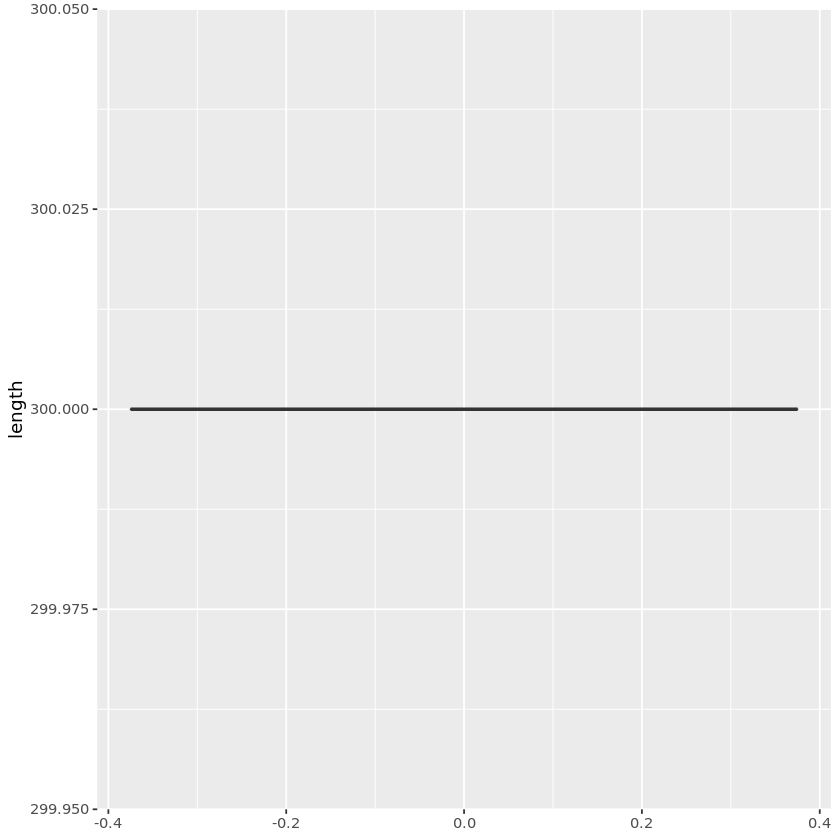

In [38]:
comb_df %>%
mutate(length = perturbation_end - perturbation_start) %>%
ggplot(aes(y = length)) +
geom_boxplot()

In [42]:
comb_df %>%
select(chr, perturbation_start, perturbation_end) %>% ### count drops to 347,482 (7974 guides targeting same site but opposite strands)
distinct() %>%
write.table("k562meta/elementReference/combined/k562.elementReference.combined.hg38.20230415.bed",
            col.names=F, row.names=F, sep = "\t", quote=F)


## Generate master hg19 elementQuant file

### Load all elementQuant files and store in one df

In [2]:
# path to the data
data_path <- 'k562meta/elementQuant/hg19'  

# set file names
files <- dir(data_path, pattern = "*.tsv", full.names = TRUE) # get file names
# files
df1 <- files %>%
  # read in all the files, appending the path before the filename
  map(~read_tsv(., col_names=TRUE, show_col_types = FALSE)) %>% 
  bind_rows()

head(df1,n=1)
dim(df1)

chrPerturbationTarget,startPerturbationTarget,endPerturbationTarget,name,EffectSize,strandPerturbationTarget,PerturbationTargetID,chrTSS,startTSS,endTSS,⋯,guideSpacerSeq,guideSeq,Significant,pValue,pValueAdjusted,PowerAtEffectSize10,PowerAtEffectSize25,PowerAtEffectSize50,ValidConnection,Notes
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<lgl>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>
chrX,46696085,46696605,chrX:46696085-46696605:.,0.03714649,.,chrX:46696085-46696605:.,chrX,48380163,48380164,⋯,NA,NA,FALSE,0.05242223,0.704383,0.9999941,1,1,TRUE,NA


[1] 4757   25

In [10]:
df1 %>%
filter(Significant == TRUE) %>%
select(name, measuredGeneSymbol) %>% distinct() %>% dim()

[1] 209   2

### Generate .bed file, then lift to hg38 coordinates

In [15]:
df1 %>%
filter(Significant == TRUE) %>%
mutate(label = paste0(name,"_",measuredGeneSymbol)) %>%
select(chrPerturbationTarget:endPerturbationTarget, label) %>%
distinct() %>%
write.table("k562meta/elementQuant/hg19_to_hg38/k562meta.elementQuant.engreitz.hg19.20230413.bed",
            col.names=F, row.names=F, sep = "\t", quote=F)

Successfully converted 209 records.

In [40]:
engreitz_hg38 <- read.delim("k562meta/elementQuant/hg19_to_hg38/k562meta.elementQuant.engreitz.hg19tohg38.20230413.bed",
                  header = FALSE, col.names = c("chr","start","end","label","drop")) %>% select(-drop) 

head(engreitz_hg38,n=1)
dim(engreitz_hg38)

,chr,start,end,label
,<chr>,<int>,<int>,<chr>
1,chrX,48521437,48521957,chrX:48379825-48380345:._EBP


[1] 209   4

## Generate master hg38 elementQuant file

In [37]:
# path to the data
data_path <- 'k562meta/elementQuant/hg38'  

# set file names
files <- dir(data_path, pattern = "*.bed.gz", full.names = TRUE) # get file names
# files
df1 <- files %>%
  # read in all the files, appending the path before the filename
  map(~read_tsv(., col_names = FALSE, show_col_types = FALSE)) %>%
  bind_rows() %>%
  mutate(X18 = as.logical(X18))  %>%
  mutate(chr = X1, start = X2, end = X3, name = X4, measuredGeneSymbol = X14, Significant = X18) %>%
  select(chr:Significant)
      

head(df1,n=1)
dim(df1)

chr,start,end,name,measuredGeneSymbol,Significant
<chr>,<dbl>,<dbl>,<chr>,<chr>,<lgl>
chr8,127735869,127736569,chr8:127735869-127736569:.,PVT1,TRUE


[1] 113   6

### Add the Engreitz elements to the Sabeti elements

In [41]:
engreitz_hg38 %>% slice_head(n=1)

chr,start,end,label
<chr>,<int>,<int>,<chr>
chrX,48521437,48521957,chrX:48379825-48380345:._EBP


In [46]:
df1 %>%
mutate(label = paste0(name,"_",measuredGeneSymbol)) %>%
select(chr:end, label) %>%
distinct() %>%
rbind(engreitz_hg38) %>%
dim() 

[1] 322   4

In [47]:
df1 %>%
mutate(label = paste0(name,"_",measuredGeneSymbol)) %>%
select(chr:end, label) %>%
distinct() %>%
rbind(engreitz_hg38) %>%
write.table("k562meta/elementQuant/combined/k562.elementQuant.combined.hg38.20230415.bed",
            col.names=F, row.names=F, sep = "\t", quote=F)

## Switch to `python` kernel

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Intersect perturbed and significant elements with 100bp bins

First, sort and merge overlapping features. Next, intersect with 100bp bins. Then, merge the adjacent bins. 

#### Input files containing perturbed and significant elements

In [2]:
%%bash
head k562meta/elementReference/combined/k562.elementReference.combined.hg38.20230415.bed -n 1
wc -l k562meta/elementReference/combined/k562.elementReference.combined.hg38.20230415.bed


chr12	111035801	111036101
347482 /data/gersbachlab/lrb53/encodeCrisprWG/finalversion/figure1/k562meta/elementReference/combined/k562.elementReference.combined.hg38.20230415.bed


In [3]:
%%bash
head k562meta/elementQuant/combined/k562.elementQuant.combined.hg38.20230415.bed -n 1
wc -l k562meta/elementQuant/combined/k562.elementQuant.combined.hg38.20230415.bed


chr8	127735869	127736569	chr8:127735869-127736569:._PVT1
322 /data/gersbachlab/lrb53/encodeCrisprWG/finalversion/figure1/k562meta/elementQuant/combined/k562.elementQuant.combined.hg38.20230415.bed


#### Sort and merge overlapping features

In [5]:
%%bash
cd k562meta/elementReference/combined/
sort -k1,1 -k2,2n k562.elementReference.combined.hg38.20230415.bed > k562.elementReference.combined.hg38.20230415.sorted.bed
wc -l k562.elementReference.combined.hg38.20230415.sorted.bed

347482 k562.elementReference.combined.hg38.20230415.sorted.bed


In [6]:
%%bash
cd k562meta/elementQuant/combined/
sort -k1,1 -k2,2n k562.elementQuant.combined.hg38.20230415.bed > k562.elementQuant.combined.hg38.20230415.sorted.bed
wc -l k562.elementQuant.combined.hg38.20230415.sorted.bed

322 k562.elementQuant.combined.hg38.20230415.sorted.bed


In [7]:
%%bash

cd k562meta/elementReference/combined/

module load bedtools2

bedtools merge -i k562.elementReference.combined.hg38.20230415.sorted.bed -d 1 > k562.elementReference.combined.hg38.20230415.sorted.merge.bed
wc -l k562.elementReference.combined.hg38.20230415.sorted.merge.bed

4052 k562.elementReference.combined.hg38.20230415.sorted.merge.bed


In [8]:
%%bash

cd k562meta/elementQuant/combined/

module load bedtools2

bedtools merge -i k562.elementQuant.combined.hg38.20230415.sorted.bed -d 1 > k562.elementQuant.combined.hg38.20230415.sorted.merge.bed
wc -l k562.elementQuant.combined.hg38.20230415.sorted.merge.bed

219 k562.elementQuant.combined.hg38.20230415.sorted.merge.bed


#### Intersect with 100bp bins

In [9]:
%%bash

cd k562meta/elementReference/combined/

module load bedtools2

bedtools intersect \
-a /path_to/binnedgenome.hg38.bed \
-b k562.elementReference.combined.hg38.20230415.sorted.merge.bed \
-wa -u | wc -l

81855


In [10]:
%%bash

cd k562meta/elementReference/combined/

module load bedtools2

bedtools intersect \
-a /path_to/binnedgenome.hg38.bed \
-b k562.elementReference.combined.hg38.20230415.sorted.merge.bed \
-wa -u | \
bedtools merge -i stdin -d 1 \
> binnedgenome.int.k562.elementReference.20230415.merge.bed

wc -l binnedgenome.int.k562.elementReference.20230415.merge.bed
head binnedgenome.int.k562.elementReference.20230415.merge.bed -n 1

2733 binnedgenome.int.k562.elementReference.20230415.merge.bed
chr3	127573700	127574600


In [11]:
%%bash

cd k562meta/elementQuant/combined/

module load bedtools2

bedtools intersect \
-a /path_to/binnedgenome.hg38.bed \
-b k562.elementQuant.combined.hg38.20230415.sorted.merge.bed \
-wa -u | wc -l

2306


In [12]:
%%bash

cd k562meta/elementQuant/combined/

module load bedtools2

bedtools intersect \
-a /path_to/binnedgenome.hg38.bed \
-b k562.elementQuant.combined.hg38.20230415.sorted.merge.bed \
-wa -u | \
bedtools merge -i stdin -d 1 \
> binnedgenome.int.k562.elementQuant.20230415.merge.bed

wc -l binnedgenome.int.k562.elementQuant.20230415.merge.bed
head binnedgenome.int.k562.elementQuant.20230415.merge.bed -n 1

210 binnedgenome.int.k562.elementQuant.20230415.merge.bed
chr3	127672600	127673300


## Calculate total bases perturbed

1. Using merged features, calculate total bases that were "covered" by a perturbation.
2. Bin the entire genome, merge bins, then calculate total bases.

#### 1. Use merged features to calculate total bases perturbed

In [13]:
df1 = pd.read_csv('k562meta/elementReference/combined/k562.elementReference.combined.hg38.20230415.sorted.merge.bed',
                   sep='\t', header = None)

df1.columns = ['chr', 'start', 'end']
# df1.head()
df1['length'] = df1['end'] - df1['start']
plotdf1 = df1.groupby(by=["chr"]).sum()
plotdf1['method'] = 'merged_only'
plotdf1.head()

,start,end,length,method
chr,,,,
chr11,23616563187,23618085908,1522721,merged_only
chr12,96299572006,96300924811,1352805,merged_only
chr19,9728963085,9729227400,264315,merged_only
chr3,23975204141,23975356810,152669,merged_only
chr4,10622178458,10622845045,666587,merged_only


#### 2. Number of bins/number of bases per chromosome.

In [14]:
df2 = pd.read_csv('k562meta/elementReference/combined/binnedgenome.int.k562.elementReference.20230415.merge.bed',
                   sep='\t', header = None)

df2.columns = ['chr', 'start', 'end']
# df2.head()
df2['length'] = df2['end'] - df2['start']
df2 = df2.drop(columns=['start','end'])
plotdf2 = df2.groupby(by=["chr"]).sum()
plotdf2['method'] = 'binned_merged'
plotdf2.head()

,length,method
chr,,
chr11,1589300,binned_merged
chr12,1434400,binned_merged
chr19,292300,binned_merged
chr3,170900,binned_merged
chr4,677300,binned_merged


In [15]:
plotdf = pd.concat([plotdf1, plotdf2], sort = False)
plotdf.index.name = 'chr'
plotdf.reset_index(inplace=True) ### make 'chr' a column instead of row names
plotdf.drop(columns=['start','end']).groupby('method').sum()

,length
method,
binned_merged,8185500
merged_only,7845325


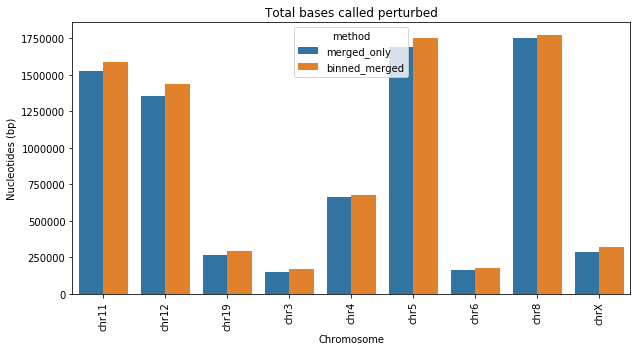

In [16]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
sns.barplot(data=plotdf, x='chr', y='length', hue='method')
plt.title("Total bases called perturbed")
plt.xlabel("Chromosome")
plt.xticks(rotation=90)
plt.ylabel("Nucleotides (bp)")
plt.show()

#### Compare percent of chromosome.

In [18]:
df3 = pd.read_csv('figure1/hg38.chromSizes.noalts.txt', header = None, sep = '\t')
df3.columns = ['chr','size']
df3 = df3.merge(plotdf, left_on='chr', right_on='chr').drop(columns=['start','end'])
df3['percent_chr'] = df3['length']/df3['size']*100
df3.head()

,chr,size,length,method,percent_chr
0,chr3,198295559,152669,merged_only,0.076991
1,chr3,198295559,170900,binned_merged,0.086184
2,chr4,190214555,666587,merged_only,0.350440
3,chr4,190214555,677300,binned_merged,0.356072
4,chr5,181538259,1685590,merged_only,0.928504


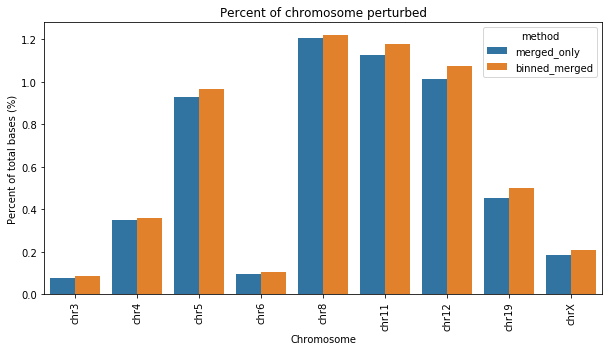

In [19]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
sns.barplot(data=df3, x='chr', y='percent_chr', hue='method')
plt.title("Percent of chromosome perturbed")
plt.xlabel("Chromosome")
plt.xticks(rotation=90)
plt.ylabel("Percent of total bases (%)")
plt.show()

## Calculate total bases significant

1. Using merged features, calculate total bases that were called significant.
2. Bin the entire genome, merge bins, then calculate total bases.

#### 1. Use merged features to calculate total bases significant

In [20]:
df1 = pd.read_csv('k562meta/elementQuant/combined/k562.elementQuant.combined.hg38.20230415.sorted.merge.bed',
                   sep='\t', header = None)

df1.columns = ['chr', 'start', 'end']
# df1.head()
df1['length'] = df1['end'] - df1['start']
plotdf1 = df1.groupby(by=["chr"]).sum()
plotdf1['method'] = 'merged_only'
plotdf1.head()

,start,end,length,method
chr,,,,
chr11,1027302100,1027354300,52200,merged_only
chr12,1534368084,1534385704,17620,merged_only
chr19,1976530664,1976573384,42720,merged_only
chr3,1802664268,1802672248,7980,merged_only
chr4,612094851,612120351,25500,merged_only


#### 2. Number of bins/number of bases per chromosome.

In [21]:
df2 = pd.read_csv('k562meta/elementQuant/combined/binnedgenome.int.k562.elementQuant.20230415.merge.bed',
                   sep='\t', header = None)

df2.columns = ['chr', 'start', 'end']
# df2.head()
df2['length'] = df2['end'] - df2['start']
df2 = df2.drop(columns=['start','end'])
plotdf2 = df2.groupby(by=["chr"]).sum()
plotdf2['method'] = 'binned_merged'
plotdf2.head()

,length,method
chr,,
chr11,54500,binned_merged
chr12,19900,binned_merged
chr19,49500,binned_merged
chr3,9400,binned_merged
chr4,26600,binned_merged


In [22]:
plotdf = pd.concat([plotdf1, plotdf2], sort = False)
plotdf.index.name = 'chr'
plotdf.reset_index(inplace=True) ### make 'chr' a column instead of row names
plotdf.drop(columns=['start','end']).groupby('method').sum()

,length
method,
binned_merged,230600
merged_only,210017


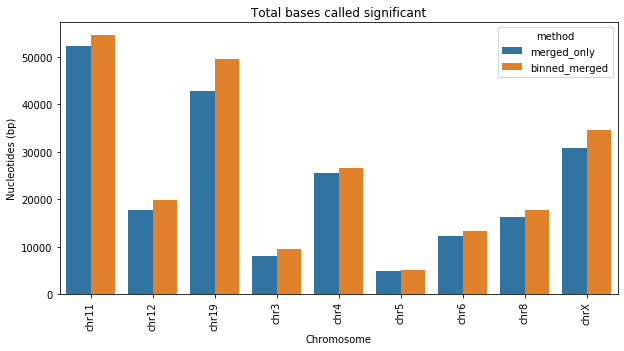

In [23]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
sns.barplot(data=plotdf, x='chr', y='length', hue='method')
plt.title("Total bases called significant")
plt.xlabel("Chromosome")
plt.xticks(rotation=90)
plt.ylabel("Nucleotides (bp)")
plt.show()

#### Compare percent of chromosome.

In [24]:
# %%bash
# cd figure1/
# cp /data/gersbachlab/lrb53/encodeCrisprWG/hg38.chromSizes.noalts.txt .

In [25]:
df3 = pd.read_csv('figure1/hg38.chromSizes.noalts.txt', header = None, sep = '\t')
df3.columns = ['chr','size']
df3 = df3.merge(plotdf, left_on='chr', right_on='chr').drop(columns=['start','end'])
df3['percent_chr'] = df3['length']/df3['size']*100
df3.head()

,chr,size,length,method,percent_chr
0,chr3,198295559,7980,merged_only,0.004024
1,chr3,198295559,9400,binned_merged,0.004740
2,chr4,190214555,25500,merged_only,0.013406
3,chr4,190214555,26600,binned_merged,0.013984
4,chr5,181538259,4800,merged_only,0.002644


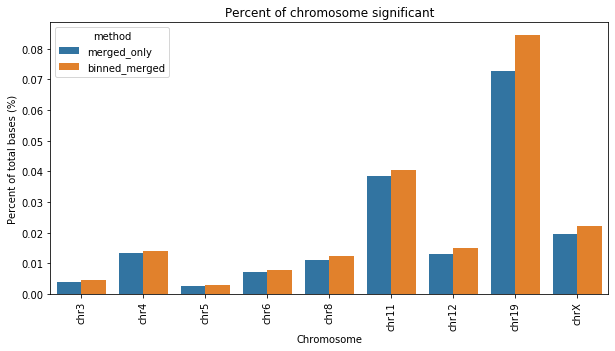

In [26]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
sns.barplot(data=df3, x='chr', y='percent_chr', hue='method')
plt.title("Percent of chromosome significant")
plt.xlabel("Chromosome")
plt.xticks(rotation=90)
plt.ylabel("Percent of total bases (%)")
plt.show()

#### Calculate percent of genome significant.

Note: the total percent of the genome will NOT equal the sum of the percent of each chromosome. <br>
Ex. (1/a) + (1/b) != 1/(a+b)

In [27]:
genomesize = df3['size'].drop_duplicates().sum() ### in the df, each chromosome has two rows (binned and merged)
genomesize

1369013430

In [28]:
df3[df3['method'] == 'binned_merged']['length'].sum()

230600

In [29]:
df3[df3['method'] == 'binned_merged']['length'].sum()/genomesize

0.00016844246736133188

In [30]:
df3[df3['method'] == 'merged_only']['length'].sum()

210017

In [31]:
df3[df3['method'] == 'merged_only']['length'].sum()/genomesize

0.000153407552765936

In [32]:
### percent of genome perturbed
8185500/3031042417*100

0.270055607077306

In [33]:
### percent of perturbed regions called significant (base pairs; binned_merged)
(230600/8185500)*100

2.817176714922729